# Assignment 2

## linear Classification Models

### Imports

In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

### A.1 binary classification

In [2]:
class binClass:
    def __init__(self, xTrain: torch.Tensor,tTrain: torch.Tensor):
        self.tT = tTrain.clone()

        ones = torch.ones((xTrain.shape[0],1), dtype=xTrain.dtype)
        self.xT = torch.cat((ones,xTrain), dim=1)

        self.w = torch.rand((self.xT.shape[1],1), requires_grad=True)

        self.N = xTrain.shape[0] # no of samples

    @staticmethod
    def lossBCE(y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        c = 1e-10
        loss = -t * torch.log(y+c) - (1-t) * torch.log(1-(y+c))

        return loss

    def train(self, epoch:int, alpha:float, xval = None, tval = None):
        self.loss = list()
        self.valloss = list()
        self.acc = list()
        self.valacc = list()

        for i in range(epoch):
            z = self.xT @ self.w
            y = torch.sigmoid(z)

            cost = binClass.lossBCE(y,self.tT).mean()
            cost.backward() # compute derivative to change w

            with torch.no_grad():
                self.loss.append(cost.item())

                pred = (y>0.5).to(torch.int8)
                pred = (pred == self.tT).int().sum() #no of correct predictions
                self.acc.append(pred)

                if(xval is not None and tval is not None):
                    yVal = torch.tensor(self.output(xval))

                    costV = binClass.lossBCE(yVal,tval).mean().item()
                    self.valloss.append(costV)

                    pred = (yVal>0.5).to(torch.int8)
                    pred = (pred == tval).int().sum()
                    self.valacc.append(pred)


            with torch.no_grad():
                self.w -= alpha * self.w.grad

            self.w.grad.zero_()


    def output(self, xTest:torch.Tensor) -> np.ndarray:
        ones = torch.ones((xTest.shape[0],1), dtype=xTest.dtype)
        x = torch.cat((ones,xTest), dim=1)

        with torch.no_grad():
            y = (x @ self.w).sigmoid()

        return y.numpy()

    def prediction(self, xTest:torch.Tensor) -> np.ndarray:
        y = self.output(xTest)
        return (y>0.5).astype(np.int8)

    def analyze(self):
        epochs = range(1, len(self.loss)+1)

        plt.subplot(211)
        plt.plot(epochs, self.loss,color="red",label="train loss")
        plt.plot(epochs, self.valloss,color="green",label="valid loss")
        plt.legend()
        plt.title("loss")

        plt.subplot(212)
        plt.plot(epochs, self.acc,color="red",label="train acc")
        plt.plot(epochs, self.valacc,color="green",label="valid acc")
        plt.legend()
        plt.title("accuracy")

        plt.show()

### A.2 Multi-class classifier

In [3]:
class mulClass:
    def __init__(self, xTrain: torch.Tensor,tTrain: torch.Tensor):
        self.tT = tTrain.clone()

        ones = torch.ones((xTrain.shape[0],1), dtype=xTrain.dtype)
        self.xT = torch.cat((ones,xTrain), dim=1)

        self.w = torch.rand((self.xT.shape[1],self.tT.shape[1]), requires_grad=True)

        self.N = xTrain.shape[0]

    @staticmethod
    def lossCE(y:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        c = 1e-10
        loss = -t * torch.log(y+c)
        loss = loss.sum(dim=1)

        return loss

    def train(self, epoch:int, alpha:float, xval = None, tval = None):
        self.loss = list()
        self.valloss = list()
        self.acc = list()
        self.valacc = list()

        for i in range(epoch):
            z = self.xT @ self.w
            y = torch.softmax(z,dim=1)

            cost = mulClass.lossCE(y,self.tT).mean()
            cost.backward()

            with torch.no_grad():
                self.loss.append(cost.item())

                pred_labels = y.argmax(dim=1)              # pick most likely class
                true_labels = torch.argmax(self.tT, dim=1)              # convert one-hot to class index
                correct = (pred_labels == true_labels).sum().item()
                acc = correct / len(true_labels)

                self.acc.append(acc)

                if(xval is not None and tval is not None):
                    yVal = torch.tensor(self.output(xval))

                    costV = mulClass.lossCE(yVal,tval).mean().item()
                    self.valloss.append(costV)

                    pred_labels = yVal.argmax(dim=1)              # pick most likely class
                    true_labels = torch.argmax(tval, dim=1)              # convert one-hot to class index
                    correct = (pred_labels == true_labels).sum().item()
                    acc = correct / len(true_labels)
                    self.valacc.append(acc)

            with torch.no_grad():
                self.w -= alpha * self.w.grad

            self.w.grad.zero_()


    def output(self, xTest:torch.Tensor) -> np.ndarray:
        ones = torch.ones((xTest.shape[0],1), dtype=xTest.dtype)
        x = torch.cat((ones,xTest), dim=1)

        with torch.no_grad():
            y = (x @ self.w).softmax(dim=1)

        return y.numpy()

    def prediction(self, xTest:torch.Tensor) -> np.ndarray:
        y = self.output(xTest)
        return (y.argmax(axis=1)).astype(np.int8)

    def analyze(self):
        epochs = range(1, len(self.loss)+1)

        plt.subplot(211)
        plt.plot(epochs, self.loss,color="red",label="train loss")
        plt.plot(epochs, self.valloss,color="green",label="valid loss")
        plt.legend()
        plt.title("loss")

        plt.subplot(212)
        plt.plot(epochs, self.acc,color="red",label="train acc")
        plt.plot(epochs, self.valacc,color="green",label="valid acc")
        plt.legend()
        plt.title("accuracy")

        plt.show()

### A.3 Running

#### A.3.1 Data preperation

In [4]:
#helper functions
def load_mnist_images(path: str):
    import struct
    with open(path, 'rb') as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051
        data = np.frombuffer(f.read(), dtype=np.uint8).copy().reshape(n, rows * cols).astype(np.float32)
        data /= 255.0    # normalize to [0,1]
    return torch.from_numpy(data)

def load_mnist_labels(path: str):
    import struct
    with open(path, 'rb') as f:
        magic, n = struct.unpack(">II", f.read(8))
        assert magic == 2049
        data = np.frombuffer(f.read(), dtype=np.uint8).copy()
    return torch.from_numpy(data)

In [5]:
X = load_mnist_images('./train-images-idx3-ubyte')
y = load_mnist_labels('./train-labels-idx1-ubyte')

In [6]:
# stratified split 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

Train: 36000, Val: 12000, Test: 12000


In [7]:
# ---------------- Helper functions ----------------
def one_hot(labels, n_classes=10):
    oh = torch.zeros(labels.size(0), n_classes)
    oh[torch.arange(labels.size(0)), labels.long()] = 1.0
    return oh

def binarise(y, pos=1):
    return (y == pos).float().view(-1,1)

#### A.3.2 Multiclass training


=== Training multiclass (softmax) ===
Softmax Test Accuracy: 64.51%


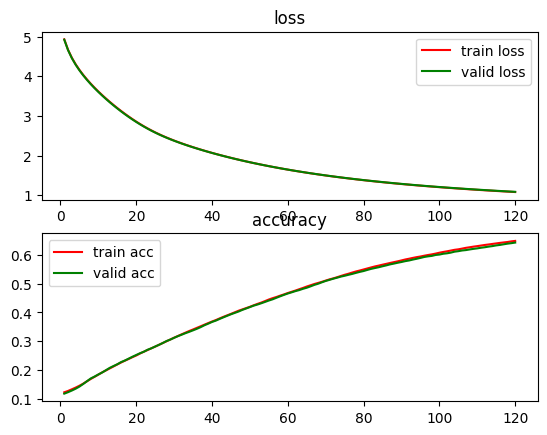

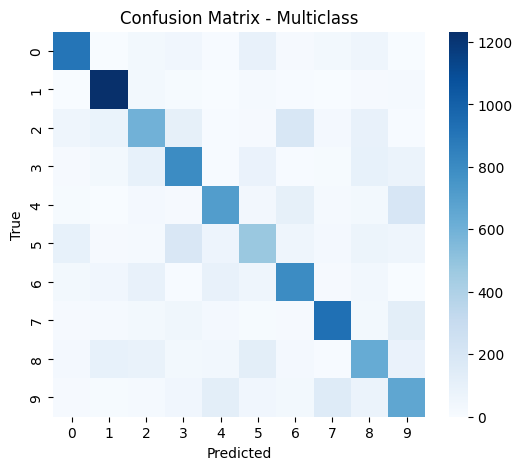

In [8]:
print("\n=== Training multiclass (softmax) ===")
t_train_mc, t_val_mc, t_test_mc = one_hot(y_train), one_hot(y_val), one_hot(y_test)
mcr = mulClass(X_train, t_train_mc)

start_time_mc = time.time()
mcr.train(epoch=120, alpha=0.05, xval=X_val, tval=t_val_mc)
train_time_mc = time.time() - start_time_mc

pred_test_mc = mcr.prediction(X_test)
acc_mc = accuracy_score(y_test, pred_test_mc)*100
print(f"Softmax Test Accuracy: {acc_mc:.2f}%")

mcr.analyze()

cm_mc = confusion_matrix(y_test, pred_test_mc)
plt.figure(figsize=(6,5))
sns.heatmap(cm_mc, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Multiclass")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

#### A.3.3 binary class training (checks for number 1)


=== Training binary (digit 1 vs rest) ===
Binary Logistic Regression Accuracy: 88.77%


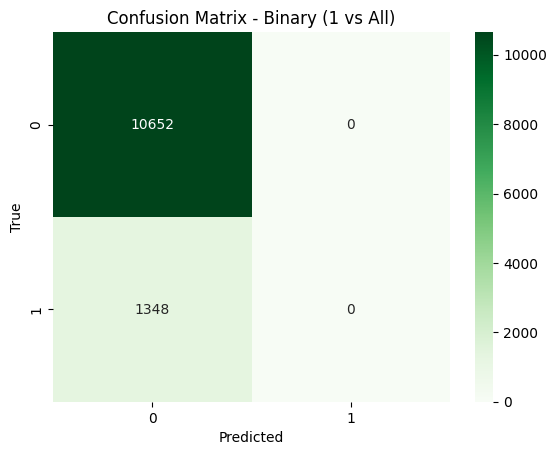

In [9]:
print("\n=== Training binary (digit 1 vs rest) ===")
t_train_bc, t_val_bc, t_test_bc = binarise(y_train,1), binarise(y_val,1), binarise(y_test,1)
bcr = binClass(X_train, t_train_bc)
start_time_bin = time.time()
bcr.train(epoch=80, alpha=0.1, xval=X_val, tval=t_val_bc)
train_time_bin = time.time() - start_time_bin
pred_test_bc = bcr.prediction(X_test).flatten()
acc_bc = accuracy_score(t_test_bc.numpy(), pred_test_bc)*100
print(f"Binary Logistic Regression Accuracy: {acc_bc:.2f}%")

cm_bc = confusion_matrix(t_test_bc.numpy().astype(int), pred_test_bc)
sns.heatmap(cm_bc, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Binary (1 vs All)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

### A.4 comparitive anylisis between multiclass and singleclass


=== Comparative Analysis ===


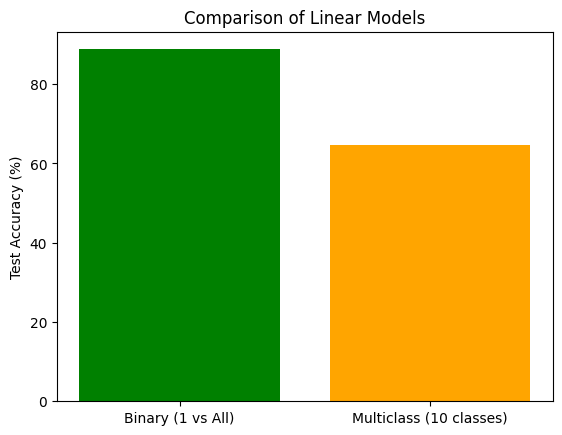

Summary:
  Binary Acc: 88.77%
  Multiclass Acc: 64.51%


In [10]:
print("\n=== Comparative Analysis ===")
labels = ["Binary (1 vs All)", "Multiclass (10 classes)"]
accs   = [acc_bc, acc_mc]
plt.bar(labels, accs, color=["green","orange"])
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Linear Models")
plt.show()

print(f"Summary:\n  Binary Acc: {acc_bc:.2f}%\n  Multiclass Acc: {acc_mc:.2f}%")

## Neural Network Models







### Imports

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
from tqdm import tqdm
import warnings
import os
from tabulate import tabulate
from matplotlib.patches import Patch
from PIL import Image
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### B1: Custom Neural Network Architecture

In [12]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10,
                 activation=nn.ReLU, dropout_rate=0.0, use_batchnorm=False):
        super(CustomNeuralNetwork, self).__init__()

        layers = []
        previous_size = input_size

        # Build hidden layers using nn.Sequential for better performance and readability
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(previous_size, hidden_size))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))

            layers.append(activation())

            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            previous_size = hidden_size

        # Output layer
        layers.append(nn.Linear(previous_size, output_size))

        self.network = nn.Sequential(*layers) #saves all layers in one object

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x): #auto called during training by pytorch
        # Flatten input (28x28 -> 784)
        x = x.view(x.size(0), -1)
        return self.network(x)



### B2: Training Infrastructure

In [13]:
class NeuralNetworkTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device=device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        # Training history
        self.history = {
            'train_losses': [], 'val_losses': [],
            'train_accuracies': [], 'val_accuracies': []
        }

    def _calculate_metrics(self, loader, criterion):
        self.model.eval() # set model to evaluation mode
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad(): # no gradient tracking for faster computation
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                total_loss += criterion(output, target).item() * data.size(0) # Sum loss
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        avg_loss = total_loss / total
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def train(self, epochs=50, learning_rate=0.01, patience=5, verbose=True):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate) #SGD as optimizer
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train() #turn on training mode
            train_loss_sum = 0.0
            train_correct = 0
            train_total = 0

            # Use tqdm for a cleaner progress bar
            for data, target in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=False):
                data, target = data.to(self.device), target.to(self.device)

                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()# update weights

                train_loss_sum += loss.item() * data.size(0)
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()

            # Calculate training metrics
            avg_train_loss = train_loss_sum / train_total
            train_accuracy = 100. * train_correct / train_total

            # --- Validation Phase ---
            avg_val_loss, val_accuracy = self._calculate_metrics(self.val_loader, criterion)

            # Store history
            self.history['train_losses'].append(avg_train_loss)
            self.history['val_losses'].append(avg_val_loss)
            self.history['train_accuracies'].append(train_accuracy)
            self.history['val_accuracies'].append(val_accuracy)

            # Early stopping check
            if avg_val_loss < best_val_loss: # to help prevent overfitting
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model state
                torch.save(self.model.state_dict(), 'best_model_temp.pth')
            else:
                patience_counter += 1

            if verbose:
                print(f'Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                if verbose:
                    print(f'Early stopping triggered at epoch {epoch+1}')
                break

        # Load best model and clean up temp file
        if os.path.exists('best_model_temp.pth'):
            self.model.load_state_dict(torch.load('best_model_temp.pth'))
            os.remove('best_model_temp.pth')

    def evaluate(self, loader):
        self.model.eval()
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)

                total += target.size(0)
                correct += (predicted == target).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        accuracy = 100. * correct / total
        return accuracy, all_predictions, all_targets

### B3: Visualization


In [14]:
def plot_training_history(trainer, model_name="Neural Network"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    axes[0].plot(trainer.history['train_losses'], label='Training Loss', linewidth=2)
    axes[0].plot(trainer.history['val_losses'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss Curves', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[1].plot(trainer.history['train_accuracies'], label='Training Accuracy', linewidth=2)
    axes[1].plot(trainer.history['val_accuracies'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy Curves', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{model_name.replace(' ', '_')}_history.png")
    plt.show() # Display plot in notebook
    plt.close(fig) # Close figure to prevent display issues in non-interactive environments

def plot_confusion_matrix(predictions, targets, model_name="Model"):
    class_names = [str(i) for i in range(10)]

    cm = confusion_matrix(targets, predictions)
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f"{model_name.replace(' ', '_')}_confusion_matrix.png")
    plt.show() # Display plot in notebook
    plt.close(fig)

    return cm

## Analysis



### C1: Hyperparameter Analysis


In [15]:
class HyperparameterAnalyzer:

    def __init__(self, train_loader, val_loader, test_loader, device=device):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.results = {}
        self.base_config = {
            'hidden_layers': [128, 64],
            'learning_rate': 0.01,
            'batch_size': 64,
            'epochs': 25
        }

    def _run_experiment(self, config, name):
        print(f"-> Running experiment: {name}")
        start_time = time.time()

        # Handle batch size change by creating a new DataLoader if necessary
        current_train_loader = self.train_loader
        if config['batch_size'] != self.base_config['batch_size']:
            original_train_dataset = self.train_loader.dataset
            current_train_loader = DataLoader(original_train_dataset, batch_size=config['batch_size'], shuffle=True)

        # Create model and trainer
        model = CustomNeuralNetwork(hidden_layers=config['hidden_layers'])
        trainer = NeuralNetworkTrainer(model, current_train_loader, self.val_loader, self.test_loader, self.device)

        # Train
        trainer.train(
            epochs=config['epochs'],
            learning_rate=config['learning_rate'],
            verbose=False,
            patience=5 # Use a fixed patience for fair comparison
        )

        # Evaluate
        val_accuracy, _, _ = trainer.evaluate(self.val_loader)
        test_accuracy, _, _ = trainer.evaluate(self.test_loader)

        training_time = time.time() - start_time

        result = {
            'trainer': trainer,
            'val_accuracy': val_accuracy,
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'final_train_loss': trainer.history['train_losses'][-1],
            'final_val_loss': trainer.history['val_losses'][-1],
            'epochs_run': len(trainer.history['train_losses']),
            'hidden_layers': config['hidden_layers']
        }

        print(f"   Result: Val Acc = {val_accuracy:.2f}%, Time = {training_time:.2f}s, Epochs: {result['epochs_run']}")
        return result

    def analyze_learning_rates(self, learning_rates=[0.001, 0.01, 0.1, 1.0]):
        print("\n=== C1.1: Learning Rate Analysis ===")
        lr_results = {}

        for lr in learning_rates:
            config = self.base_config.copy()
            config['learning_rate'] = lr
            lr_results[lr] = self._run_experiment(config, f"LR={lr}")

        self.results['learning_rates'] = lr_results
        return lr_results

    def analyze_batch_sizes(self, batch_sizes=[16, 32, 64, 128]):
        print("\n=== C1.2: Batch Size Analysis ===")
        bs_results = {}

        for bs in batch_sizes:
            config = self.base_config.copy()
            config['batch_size'] = bs
            bs_results[bs] = self._run_experiment(config, f"BS={bs}")

        self.results['batch_sizes'] = bs_results
        return bs_results

    def analyze_architectures(self, architectures):
        print("\n=== C1.3: Architecture Analysis ===")
        arch_results = {}

        for arch_name, hidden_layers in architectures.items():
            config = self.base_config.copy()
            config['hidden_layers'] = hidden_layers
            arch_results[arch_name] = self._run_experiment(config, f"Arch={arch_name}")

        self.results['architectures'] = arch_results
        return arch_results





    def plot_hyperparameter_analysis(self):
        # Learning Rate Analysis Plot
        if 'learning_rates' not in self.results:
            print("No learning rate results found to plot.")
            return

        lr_data = self.results['learning_rates']
        fig = plt.figure(figsize=(12, 8))

        for lr, data in lr_data.items():
            if 'trainer' in data:
                history = data['trainer'].history['val_accuracies']
                epochs = range(1, len(history) + 1)
                plt.plot(epochs, history, 'o-', linewidth=2, markersize=4, label=f'LR = {lr}')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Validation Accuracy (%)', fontsize=12)
        plt.title('Learning Curve Analysis (Epoch vs. Accuracy)', fontsize=14, fontweight='bold')
        plt.legend()  # Add a legend to identify the lines
        plt.grid(True, alpha=0.4)
        plt.savefig("Learning_Curves_Analysis.png")
        plt.show()
        plt.close(fig)

        # Batch Size Analysis Plot
        if 'batch_sizes' in self.results:
            bs_data = self.results['batch_sizes']
            batch_sizes = list(bs_data.keys())
            val_accs = [bs_data[bs]['val_accuracy'] for bs in batch_sizes]
            times = [bs_data[bs]['training_time'] for bs in batch_sizes]

            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            axes[0].plot(batch_sizes, val_accs, 'ro-', linewidth=2, markersize=8)
            axes[0].set_xlabel('Batch Size', fontsize=12)
            axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
            axes[0].set_title('Batch Size vs Accuracy', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)

            axes[1].plot(batch_sizes, times, 'go-', linewidth=2, markersize=8)
            axes[1].set_xlabel('Batch Size', fontsize=12)
            axes[1].set_ylabel('Training Time (s)', fontsize=12)
            axes[1].set_title('Batch Size vs Training Time', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig("BS_Analysis.png")
            plt.show()
            plt.close(fig)

        # Architecture Analysis Plot
        if 'architectures' in self.results:
            arch_data = self.results['architectures']
            arch_names = list(arch_data.keys())
            val_accs = [arch_data[arch]['val_accuracy'] for arch in arch_names]

            fig = plt.figure(figsize=(12, 6))
            bars = plt.bar(arch_names, val_accs, color='skyblue', alpha=0.7)
            plt.xlabel('Architecture', fontsize=12)
            plt.ylabel('Validation Accuracy (%)', fontsize=12)
            plt.title('Architecture Comparison', fontsize=14, fontweight='bold')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3, axis='y')

            # Add value labels on bars
            for bar, acc in zip(bars, val_accs):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

            plt.tight_layout()
            plt.savefig("Arch_Analysis.png")
            plt.show()
            plt.close(fig)



### C2: Model Comparison

In [16]:

def compare_models(linear_models_results, neural_network_results):
    comparison_data = []

    for model_name, results in linear_models_results.items():
        comparison_data.append({
            'Model': model_name,
            'Type': 'Linear',
            'Test Accuracy': results['test_accuracy'],
            'Training Time (s)': results.get('training_time', 'N/A'),
            'Parameters': results.get('parameters', 'N/A')
        })

    # Add neural network results
    for model_name, results in neural_network_results.items():
        comparison_data.append({
            'Model': model_name,
            'Type': 'Neural Network',
            'Test Accuracy': results['test_accuracy'],
            'Training Time (s)': results.get('training_time', 'N/A'),
            'Parameters': results.get('parameters', 'N/A')
        })

    # Create comparison table (for display)
    print("\n" + "="*60)
    print("C2: COMPREHENSIVE MODEL COMPARISON TABLE")
    print("="*60)

    table_data = []
    for data in comparison_data:
        table_data.append([
            data['Model'],
            data['Type'],
            f"{data['Test Accuracy']:.2f}%",
            f"{data['Training Time (s)']:.2f}" if isinstance(data['Training Time (s)'], (int, float)) else data['Training Time (s)'],
            data['Parameters']
        ])

    print(tabulate(table_data, headers=['Model', 'Type', 'Test Accuracy', 'Training Time (s)', 'Parameters'], tablefmt="fancy_grid"))

    # Visualization
    models = [data['Model'] for data in comparison_data]
    accuracies = [data['Test Accuracy'] for data in comparison_data]
    types = [data['Type'] for data in comparison_data]

    colors = ['red' if t == 'Linear' else 'blue' for t in types]

    fig = plt.figure(figsize=(12, 6))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Model Comparison: Test Accuracy', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Add legend
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label='Linear Models'),
        Patch(facecolor='blue', alpha=0.7, label='Neural Networks')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()
    plt.savefig("Model_Comparison.png")
    plt.show()
    plt.close(fig)

    return comparison_data


### Data loading for NN

In [17]:
def load_and_prepare_data():
    # Download and load datasets
    train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True)

    # Combine all data (60k train + 10k test = 70k total)
    all_images = np.concatenate([train_dataset.data.numpy(), test_dataset.data.numpy()])
    all_labels = np.concatenate([train_dataset.targets.numpy(), test_dataset.targets.numpy()])

    print(f"Total dataset size: {len(all_images)} samples")

    # SPLIT: 60% train, 40% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_images, all_labels,
        train_size=0.6,
        stratify=all_labels,
        random_state=42
    )

    # Split temp into 20% val, 20% test (50/50 of 40%)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=0.5,
        stratify=y_temp,
        random_state=42
    )

    transform_nn = transforms.Compose([
        transforms.ToTensor(), # converts to [0,1] and to tensor
    ])

    # Create TensorDatasets
    train_data_nn = [(transform_nn(Image.fromarray(img.astype(np.uint8), mode='L')), label)
                     for img, label in zip(X_train, y_train)]
    val_data_nn = [(transform_nn(Image.fromarray(img.astype(np.uint8), mode='L')), label)
                   for img, label in zip(X_val, y_val)]
    test_data_nn = [(transform_nn(Image.fromarray(img.astype(np.uint8), mode='L')), label)
                    for img, label in zip(X_test, y_test)]

    # Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(train_data_nn, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data_nn, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data_nn, batch_size=batch_size, shuffle=False)

    return (
        train_loader, val_loader, test_loader,
    )

### Main function

Loading and preparing data...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]


Total dataset size: 70000 samples

PART B: NEURAL NETWORK IMPLEMENTATION
Baseline Model architecture: CustomNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total parameters: 109,386

B2: Training Baseline Neural Network...


Epoch 1/30: Train Loss: 1.0666, Train Acc: 72.36% | Val Loss: 0.5199, Val Acc: 86.56% | Patience: 0/5


Epoch 2/30: Train Loss: 0.4256, Train Acc: 88.49% | Val Loss: 0.3759, Val Acc: 89.75% | Patience: 0/5


Epoch 3/30: Train Loss: 0.3388, Train Acc: 90.58% | Val Loss: 0.3334, Val Acc: 90.37% | Patience: 0/5


Epoch 4/30: Train Loss: 0.2986, Train Acc: 91.46% | Val Loss: 0.2955, Val Acc: 91.56% | Patience: 0/5


Epoch 5/30: Train Loss: 0.2716, Train Acc: 92.27% | Val Loss: 0.2754, Val Acc: 92.14% | Patience: 0/5


Epoch 6/30: Train Loss: 0.2512, Train Acc: 92.85% | Val Loss: 0.2573, Val Acc: 92.46% | Patience: 0/5


Epoch 7/30: Train Loss: 0.2347, Train Acc: 93.27% | Val Loss: 0.2425, Val Acc: 93.07% | Patience: 0/5


Epoch 8/30: Train Loss: 0.2199, Train Acc: 93.63% | Val Loss: 0.2307, Val Acc: 93.45% | Patience: 0/5


Epoch 9/30: Train Loss: 0.2072, Train Acc: 94.06% | Val Loss: 0.2206, Val Acc: 93.59% | Patience: 0/5


Epoch 10/30: Train Loss: 0.1962, Train Acc: 94.38% | Val Loss: 0.2123, Val Acc: 93.84% | Patience: 0/5


Epoch 11/30: Train Loss: 0.1857, Train Acc: 94.63% | Val Loss: 0.2032, Val Acc: 94.09% | Patience: 0/5


Epoch 12/30: Train Loss: 0.1765, Train Acc: 94.90% | Val Loss: 0.1934, Val Acc: 94.47% | Patience: 0/5


Epoch 13/30: Train Loss: 0.1677, Train Acc: 95.10% | Val Loss: 0.1898, Val Acc: 94.56% | Patience: 0/5


Epoch 14/30: Train Loss: 0.1600, Train Acc: 95.42% | Val Loss: 0.1803, Val Acc: 94.93% | Patience: 0/5


Epoch 15/30: Train Loss: 0.1534, Train Acc: 95.60% | Val Loss: 0.1756, Val Acc: 95.00% | Patience: 0/5


Epoch 16/30: Train Loss: 0.1467, Train Acc: 95.81% | Val Loss: 0.1761, Val Acc: 94.95% | Patience: 1/5


Epoch 17/30: Train Loss: 0.1405, Train Acc: 95.99% | Val Loss: 0.1637, Val Acc: 95.16% | Patience: 0/5


Epoch 18/30: Train Loss: 0.1348, Train Acc: 96.14% | Val Loss: 0.1679, Val Acc: 95.10% | Patience: 1/5


Epoch 19/30: Train Loss: 0.1297, Train Acc: 96.29% | Val Loss: 0.1563, Val Acc: 95.46% | Patience: 0/5


Epoch 20/30: Train Loss: 0.1250, Train Acc: 96.45% | Val Loss: 0.1520, Val Acc: 95.50% | Patience: 0/5


Epoch 21/30: Train Loss: 0.1202, Train Acc: 96.56% | Val Loss: 0.1536, Val Acc: 95.59% | Patience: 1/5


Epoch 22/30: Train Loss: 0.1160, Train Acc: 96.73% | Val Loss: 0.1455, Val Acc: 95.75% | Patience: 0/5


Epoch 23/30: Train Loss: 0.1120, Train Acc: 96.82% | Val Loss: 0.1417, Val Acc: 95.77% | Patience: 0/5


Epoch 24/30: Train Loss: 0.1080, Train Acc: 96.91% | Val Loss: 0.1377, Val Acc: 95.89% | Patience: 0/5


Epoch 25/30: Train Loss: 0.1042, Train Acc: 97.03% | Val Loss: 0.1370, Val Acc: 95.94% | Patience: 0/5


Epoch 26/30: Train Loss: 0.1010, Train Acc: 97.17% | Val Loss: 0.1333, Val Acc: 95.99% | Patience: 0/5


Epoch 27/30: Train Loss: 0.0978, Train Acc: 97.20% | Val Loss: 0.1313, Val Acc: 96.16% | Patience: 0/5


Epoch 28/30: Train Loss: 0.0945, Train Acc: 97.31% | Val Loss: 0.1294, Val Acc: 96.13% | Patience: 0/5


Epoch 29/30: Train Loss: 0.0917, Train Acc: 97.43% | Val Loss: 0.1281, Val Acc: 96.17% | Patience: 0/5


Epoch 30/30: Train Loss: 0.0889, Train Acc: 97.49% | Val Loss: 0.1253, Val Acc: 96.24% | Patience: 0/5

B3: Generating Performance Visualizations...


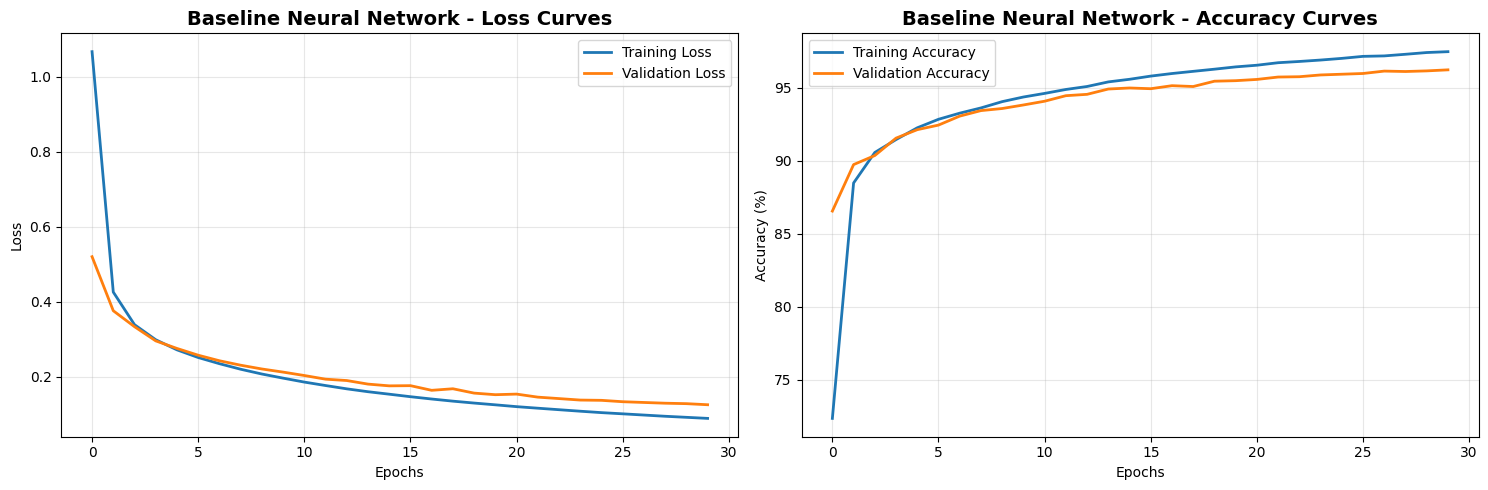


Baseline Test Accuracy: 96.41%


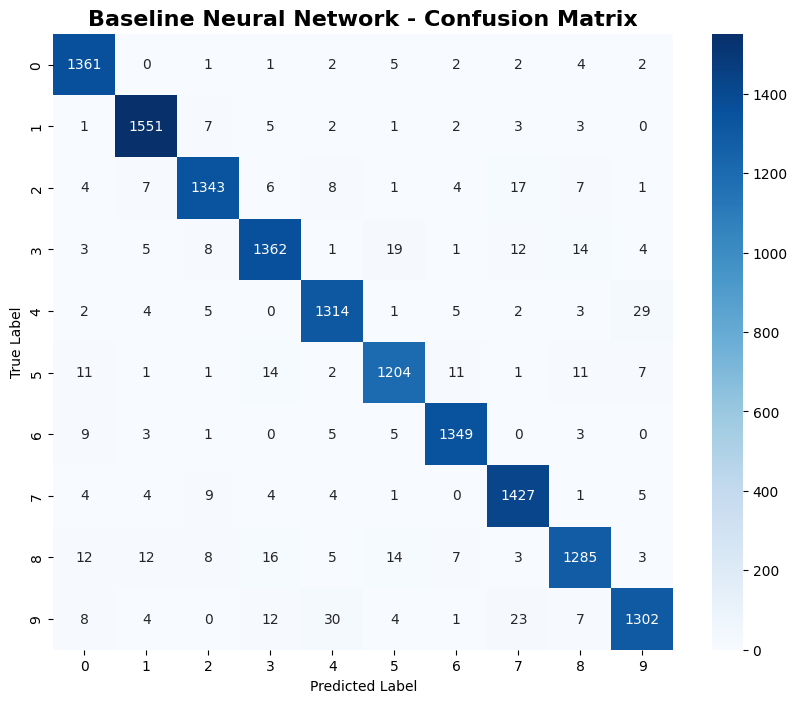


PART C: COMPREHENSIVE ANALYSIS

=== C1.1: Learning Rate Analysis ===
-> Running experiment: LR=0.001


   Result: Val Acc = 90.26%, Time = 34.02s, Epochs: 25
-> Running experiment: LR=0.01


   Result: Val Acc = 95.69%, Time = 32.62s, Epochs: 25
-> Running experiment: LR=0.1


   Result: Val Acc = 97.42%, Time = 23.53s, Epochs: 18
-> Running experiment: LR=1.0


   Result: Val Acc = 95.19%, Time = 26.10s, Epochs: 20

=== C1.2: Batch Size Analysis ===
-> Running experiment: BS=16


   Result: Val Acc = 97.28%, Time = 104.12s, Epochs: 25
-> Running experiment: BS=32


   Result: Val Acc = 96.64%, Time = 56.79s, Epochs: 25
-> Running experiment: BS=64


   Result: Val Acc = 95.86%, Time = 32.54s, Epochs: 25
-> Running experiment: BS=128


   Result: Val Acc = 94.06%, Time = 20.38s, Epochs: 25

=== C1.3: Architecture Analysis ===
-> Running experiment: Arch=2 Layers 


   Result: Val Acc = 95.67%, Time = 32.39s, Epochs: 25
-> Running experiment: Arch=3 Layers 


   Result: Val Acc = 96.70%, Time = 36.41s, Epochs: 25
-> Running experiment: Arch=4 Layers 


   Result: Val Acc = 97.07%, Time = 40.94s, Epochs: 25
-> Running experiment: Arch=5 Layers 


   Result: Val Acc = 96.88%, Time = 42.94s, Epochs: 25

Generating Hyperparameter Analysis Plots...


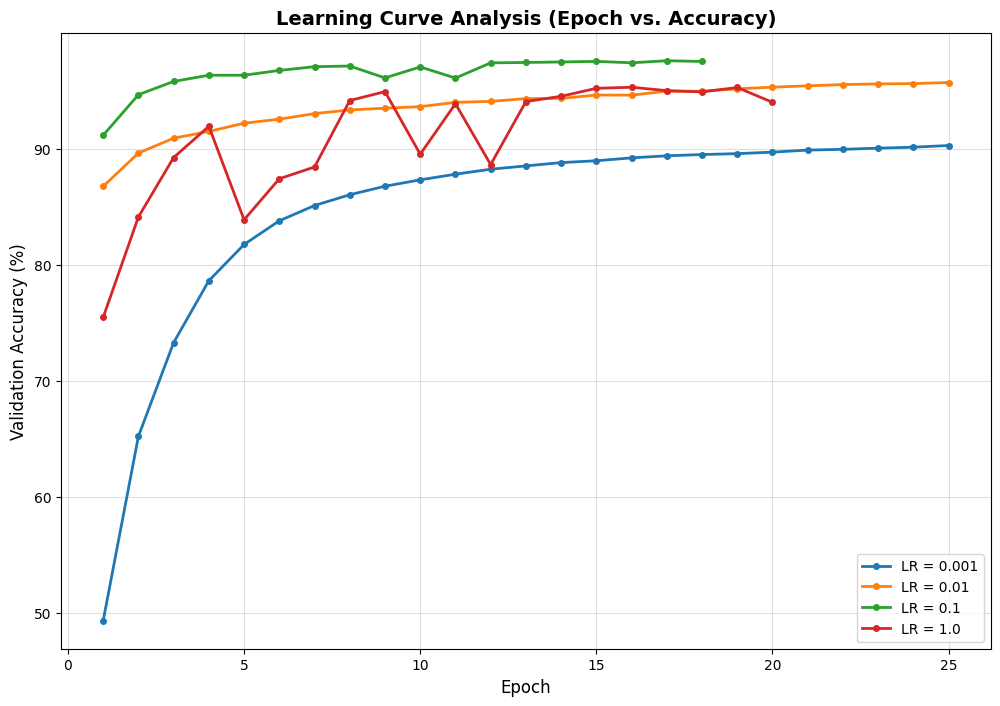

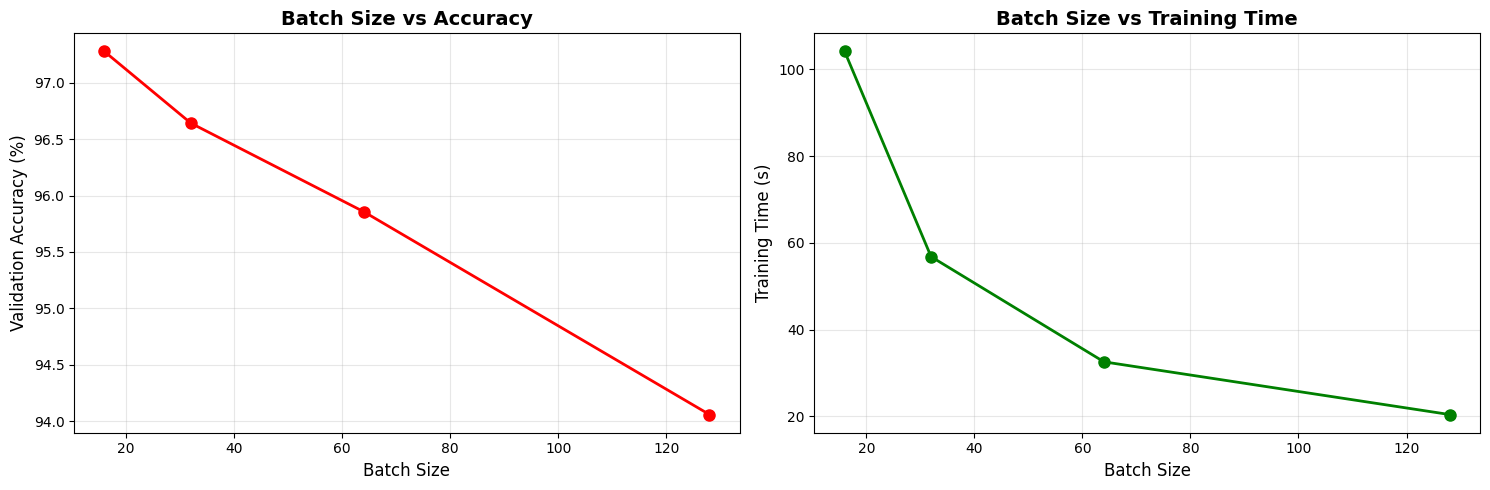

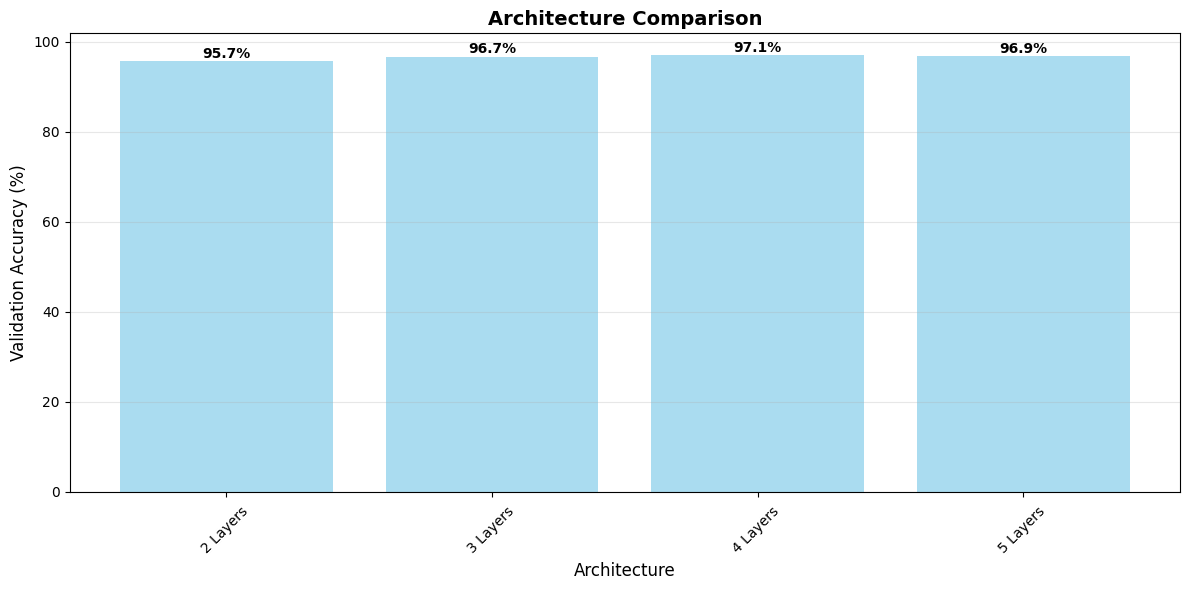


C2: Model Comparison ...


C2: COMPREHENSIVE MODEL COMPARISON TABLE
╒════════════════════════╤════════════════╤═════════════════╤═════════════════════╤══════════════╕
│ Model                  │ Type           │ Test Accuracy   │   Training Time (s) │   Parameters │
╞════════════════════════╪════════════════╪═════════════════╪═════════════════════╪══════════════╡
│ Logistic Regression    │ Linear         │ 88.77%          │                3.66 │          785 │
├────────────────────────┼────────────────┼─────────────────┼─────────────────────┼──────────────┤
│ Softmax Regression     │ Linear         │ 64.51%          │               13.08 │         7850 │
├────────────────────────┼────────────────┼─────────────────┼─────────────────────┼──────────────┤
│ Baseline NN            │ Neural Network │ 96.41%          │               39.96 │       109386 │
├────────────────────────┼────────────────┼─────────────────┼─────────────────────┼──────────────┤
│ Optimal NN (4 Layers ) │ Neural Networ

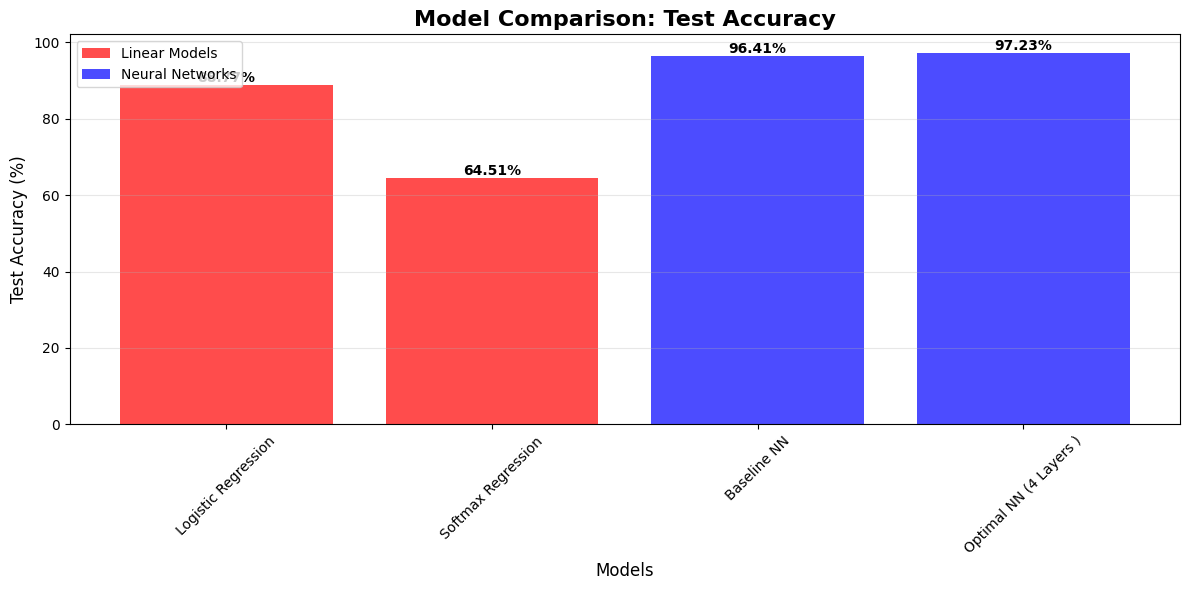


FINAL BEST MODEL EVALUATION
Training optimal model: 4 Layers ...


Epoch 1/50: Train Loss: 1.0477, Train Acc: 70.69% | Val Loss: 0.4334, Val Acc: 88.01% | Patience: 0/5


Epoch 2/50: Train Loss: 0.3497, Train Acc: 90.13% | Val Loss: 0.3216, Val Acc: 90.62% | Patience: 0/5


Epoch 3/50: Train Loss: 0.2773, Train Acc: 92.14% | Val Loss: 0.2671, Val Acc: 92.09% | Patience: 0/5


Epoch 4/50: Train Loss: 0.2344, Train Acc: 93.28% | Val Loss: 0.2444, Val Acc: 92.86% | Patience: 0/5


Epoch 5/50: Train Loss: 0.2033, Train Acc: 94.16% | Val Loss: 0.2127, Val Acc: 93.80% | Patience: 0/5


Epoch 6/50: Train Loss: 0.1792, Train Acc: 94.90% | Val Loss: 0.1967, Val Acc: 94.06% | Patience: 0/5


Epoch 7/50: Train Loss: 0.1604, Train Acc: 95.46% | Val Loss: 0.2010, Val Acc: 93.96% | Patience: 1/5


Epoch 8/50: Train Loss: 0.1437, Train Acc: 95.90% | Val Loss: 0.1725, Val Acc: 94.89% | Patience: 0/5


Epoch 9/50: Train Loss: 0.1304, Train Acc: 96.35% | Val Loss: 0.1602, Val Acc: 95.26% | Patience: 0/5


Epoch 10/50: Train Loss: 0.1182, Train Acc: 96.63% | Val Loss: 0.1505, Val Acc: 95.35% | Patience: 0/5


Epoch 11/50: Train Loss: 0.1073, Train Acc: 96.95% | Val Loss: 0.1589, Val Acc: 95.29% | Patience: 1/5


Epoch 12/50: Train Loss: 0.0988, Train Acc: 97.15% | Val Loss: 0.1301, Val Acc: 96.09% | Patience: 0/5


Epoch 13/50: Train Loss: 0.0905, Train Acc: 97.43% | Val Loss: 0.1286, Val Acc: 96.25% | Patience: 0/5


Epoch 14/50: Train Loss: 0.0831, Train Acc: 97.62% | Val Loss: 0.1214, Val Acc: 96.45% | Patience: 0/5


Epoch 15/50: Train Loss: 0.0766, Train Acc: 97.75% | Val Loss: 0.1201, Val Acc: 96.41% | Patience: 0/5


Epoch 16/50: Train Loss: 0.0709, Train Acc: 97.97% | Val Loss: 0.1128, Val Acc: 96.56% | Patience: 0/5


Epoch 17/50: Train Loss: 0.0651, Train Acc: 98.21% | Val Loss: 0.1082, Val Acc: 96.68% | Patience: 0/5


Epoch 18/50: Train Loss: 0.0591, Train Acc: 98.38% | Val Loss: 0.1107, Val Acc: 96.69% | Patience: 1/5


Epoch 19/50: Train Loss: 0.0549, Train Acc: 98.51% | Val Loss: 0.1057, Val Acc: 96.80% | Patience: 0/5


Epoch 20/50: Train Loss: 0.0510, Train Acc: 98.62% | Val Loss: 0.1011, Val Acc: 96.89% | Patience: 0/5


Epoch 21/50: Train Loss: 0.0470, Train Acc: 98.75% | Val Loss: 0.1003, Val Acc: 96.87% | Patience: 0/5


Epoch 22/50: Train Loss: 0.0425, Train Acc: 98.88% | Val Loss: 0.1009, Val Acc: 96.91% | Patience: 1/5


Epoch 23/50: Train Loss: 0.0396, Train Acc: 98.94% | Val Loss: 0.1031, Val Acc: 96.79% | Patience: 2/5


Epoch 24/50: Train Loss: 0.0363, Train Acc: 99.08% | Val Loss: 0.1053, Val Acc: 96.84% | Patience: 3/5


Epoch 25/50: Train Loss: 0.0340, Train Acc: 99.12% | Val Loss: 0.0974, Val Acc: 96.99% | Patience: 0/5


Epoch 26/50: Train Loss: 0.0310, Train Acc: 99.23% | Val Loss: 0.1022, Val Acc: 96.94% | Patience: 1/5


Epoch 27/50: Train Loss: 0.0281, Train Acc: 99.32% | Val Loss: 0.0937, Val Acc: 97.19% | Patience: 0/5


Epoch 28/50: Train Loss: 0.0260, Train Acc: 99.40% | Val Loss: 0.0988, Val Acc: 97.09% | Patience: 1/5


Epoch 29/50: Train Loss: 0.0241, Train Acc: 99.45% | Val Loss: 0.0947, Val Acc: 97.18% | Patience: 2/5


Epoch 30/50: Train Loss: 0.0223, Train Acc: 99.53% | Val Loss: 0.0927, Val Acc: 97.24% | Patience: 0/5


Epoch 31/50: Train Loss: 0.0204, Train Acc: 99.60% | Val Loss: 0.1016, Val Acc: 97.06% | Patience: 1/5


Epoch 32/50: Train Loss: 0.0184, Train Acc: 99.67% | Val Loss: 0.0940, Val Acc: 97.26% | Patience: 2/5


Epoch 33/50: Train Loss: 0.0171, Train Acc: 99.70% | Val Loss: 0.0951, Val Acc: 97.30% | Patience: 3/5


Epoch 34/50: Train Loss: 0.0156, Train Acc: 99.76% | Val Loss: 0.0941, Val Acc: 97.17% | Patience: 4/5


Epoch 35/50: Train Loss: 0.0146, Train Acc: 99.78% | Val Loss: 0.0936, Val Acc: 97.34% | Patience: 5/5
Early stopping triggered at epoch 35

🎯 FINAL OPTIMAL MODEL TEST ACCURACY: 97.46%

Detailed Classification Report:
              precision    recall  f1-score   support

           0      0.973     0.991     0.982      1380
           1      0.988     0.989     0.988      1575
           2      0.975     0.977     0.976      1398
           3      0.968     0.966     0.967      1429
           4      0.974     0.971     0.972      1365
           5      0.976     0.964     0.970      1263
           6      0.980     0.986     0.983      1375
           7      0.977     0.979     0.978      1459
           8      0.967     0.959     0.963      1365
           9      0.966     0.963     0.964      1391

    accuracy                          0.975     14000
   macro avg      0.974     0.974     0.974     14000
weighted avg      0.975     0.975     0.975     14000



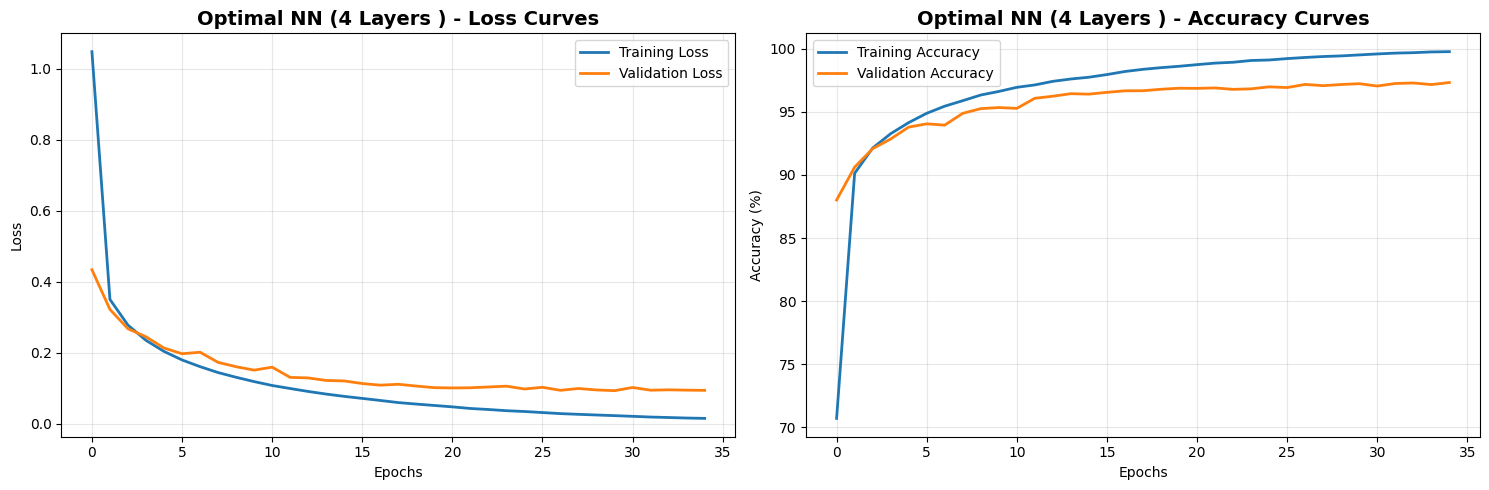

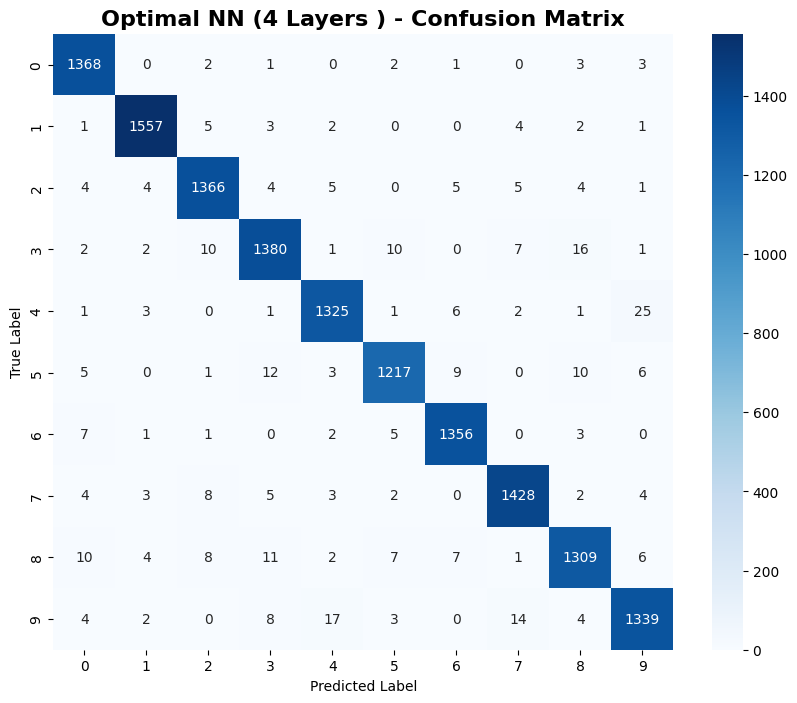

In [18]:
def main():
    print("Loading and preparing data...")
    train_loader, val_loader, test_loader = load_and_prepare_data()

    print("\n" + "="*50)
    print("PART B: NEURAL NETWORK IMPLEMENTATION")
    print("="*50)

    # B1: Create baseline neural network
    model = CustomNeuralNetwork(
        input_size=784, # no of pixels in the dataset images 28x28
        hidden_layers=[128, 64],  # Baseline architecture
        output_size=10 # 10 numbers from 0 to 9
    )
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Baseline Model architecture: {model}")
    print(f"Total parameters: {total_params:,}")

    # B2: Train the model
    print("\nB2: Training Baseline Neural Network...")
    trainer = NeuralNetworkTrainer(model, train_loader, val_loader, test_loader, device)

    # Measure training time for comparison
    start_time_b = time.time()
    trainer.train(epochs=30, learning_rate=0.01, verbose=True)
    training_time_b = time.time() - start_time_b

    # B3: Performance Visualization
    print("\nB3: Generating Performance Visualizations...")
    plot_training_history(trainer, "Baseline Neural Network")

    # Evaluate on test set
    test_accuracy_b, test_predictions_b, test_targets_b = trainer.evaluate(test_loader)
    print(f"\nBaseline Test Accuracy: {test_accuracy_b:.2f}%")

    # Plot confusion matrix
    plot_confusion_matrix(test_predictions_b, test_targets_b, "Baseline Neural Network")

    print("\n" + "="*50)
    print("PART C: COMPREHENSIVE ANALYSIS")
    print("="*50)

    # C1: Hyperparameter Analysis
    analyzer = HyperparameterAnalyzer(train_loader, val_loader, test_loader, device)

    # Learning rate analysis
    lr_results = analyzer.analyze_learning_rates(
        learning_rates=[0.001, 0.01, 0.1, 1.0]
    )

    # Batch size analysis
    bs_results = analyzer.analyze_batch_sizes(
        batch_sizes=[16, 32, 64, 128]
    )

    # Architecture analysis
    architectures = {
    '2 Layers ': [128, 64],
    '3 Layers ': [256, 128, 64],
    '4 Layers ': [512, 256, 128, 64],
    '5 Layers ': [512, 256, 128, 64, 32]
    }
    arch_results = analyzer.analyze_architectures(
        architectures=architectures
    )

    # Plot all analysis results
    print("\nGenerating Hyperparameter Analysis Plots...")
    analyzer.plot_hyperparameter_analysis()

    # C2: Model Comparison
    print("\nC2: Model Comparison ...\n")


    linear_models_results = { #results from part A
        'Logistic Regression': {'test_accuracy': acc_bc, 'training_time': train_time_bin, 'parameters': bcr.w.numel()},
        'Softmax Regression': {'test_accuracy': acc_mc, 'training_time': train_time_mc, 'parameters': mcr.w.numel()}
    }

    # Find the best NN from the architecture analysis
    best_arch_name, best_arch_result = max(arch_results.items(), key=lambda x: x[1]['val_accuracy'])

    neural_network_results = {
        'Baseline NN': {'test_accuracy': test_accuracy_b, 'training_time': training_time_b, 'parameters': total_params},
        f'Optimal NN ({best_arch_name})': {'test_accuracy': best_arch_result['test_accuracy'], 'training_time': best_arch_result['training_time'], 'parameters': sum(p.numel() for p in CustomNeuralNetwork(hidden_layers=best_arch_result['hidden_layers']).parameters())}
    }

    compare_models(linear_models_results, neural_network_results)

    # Final evaluation of the best model
    print("\n" + "="*50)
    print("FINAL BEST MODEL EVALUATION")
    print("="*50)

    # Train best model with more epochs
    print(f"Training optimal model: {best_arch_name}...")
    optimal_model = CustomNeuralNetwork(hidden_layers=best_arch_result['hidden_layers'])
    optimal_trainer = NeuralNetworkTrainer(optimal_model, train_loader, val_loader, test_loader, device)
    optimal_trainer.train(epochs=50, learning_rate=0.01, verbose=True)

    # Final evaluation
    final_test_accuracy, final_predictions, final_targets = optimal_trainer.evaluate(test_loader)
    print(f"\n🎯 FINAL OPTIMAL MODEL TEST ACCURACY: {final_test_accuracy:.2f}%")

    # Detailed analysis of misclassifications
    print("\nDetailed Classification Report:")
    print(classification_report(final_targets, final_predictions, digits=3))

    # Plot final results
    plot_training_history(optimal_trainer, f"Optimal NN ({best_arch_name})")
    plot_confusion_matrix(final_predictions, final_targets, f"Optimal NN ({best_arch_name})")

if __name__ == "__main__":
    main()